# Navier-Stokes with a pivot-fixed falling flat plate 
## Using `Whirl` and `Dyn3d`

In [38]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d

In [39]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

In [40]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dFall.jl")

Config info set up.


#### Build joint-body chain

In [41]:
# build joint-body chain
bodys, joints, system = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bodys, joints, system)

#### Initialize rigid body system state

In [42]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

This is a 1 body-joint system.
System is fixed in space


#### Set up HERKBody object

In [43]:
herkbody = Dyn3d.HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Genrate body grid points and get linear velocity on them

In [44]:
# generate body points and fit it into 2d
# note: np = (# of points on 1d plate - 1)*4+1. So np=101 has 26 points
# and np=201 has 51 points, np=49 has 13 points

bgs = GenerateBodyGrid(bd; np=201)
bgs = CutOut2d(bd,bgs)
bgs = AcquireBodyGridKinematics(bd,bgs)

coord = hcat(bgs[1].q_i...)'[:,[1,2]]
motion = hcat(bgs[1].v_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
    motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
end

#### Variable containers for all stages in IFHERK and HERKBody

In [45]:
# Herk stages for both body and fluid solver
NS = 3

# Body kinematics container for ifherk input and herkbody output
bkins = Vector{Array{Float64,2}}(NS)

# Body force container for ifherk output(not integrated)
fs = Vector{Array{Float64,2}}(NS)

# Body force container for herkbody input(integrated)
f_exis = [zeros(bd.sys.nbody,6) for i=1:NS]

# All body info container
bds = [bd for i=1:NS];

#### Prepare for the special treatment on the first timestep

In [46]:
# using Interpolations

# coords_init2 = Array{Float64,2}[]
# motions_init2 = Array{Float64,2}[]
# push!(coords_init2,coord)
# push!(motions_init2,motion);

#### Get body verts for plotting

In [47]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, solns[1].qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

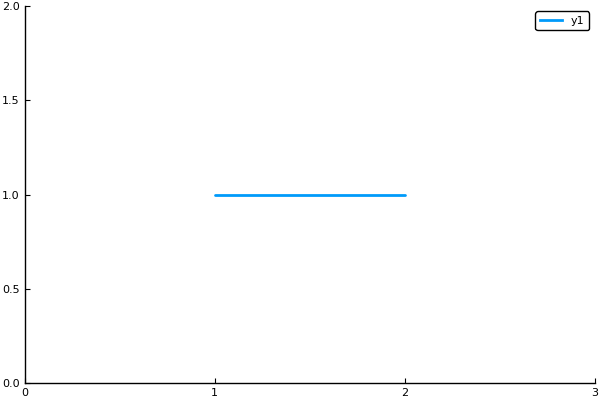

In [48]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid solver with Whirl </span>

#### Set the flow parameters

In [49]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (0.0,U);

#### Set the domain size and time step size

In [50]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

#### Set up initial conditions

In [51]:
t = 0.0
w₀ .= 0.0
tf = 2*Δt
T = Δt:Δt:tf
fx = Float64[]
fy = Float64[]
thist = []
uhist = []
tsample = 0.02;

#### Get body points initial coordinates

In [52]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end
coord_init = coord;

#### Set up the Navier-Stokes  problem type

In [53]:
X̃ = VectorData(coord_init)
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 152 x 102

## <span style="color:blue"> Preparation for Time Marching </span>

#### Constants for coupling

In [54]:
tol = 5e-4
ω = (config_bodys[1].ρ)/(1.0+config_bodys[1].ρ)

0.5

#### Create Body solver object of type HerkBody

In [55]:
# construct body solver
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
            (HERKFuncf,HERKFuncgti),
            (UpdatePosition!,UpdateVelocity!))

Order-3 HERK integrator.


#### Create Fluid solver object of type IFHERK

In [56]:
u = w₀
f = VectorData(X̃)
f_init = [[f.u f.v] for i=1:NS]

# construct fluid solver with uniform constant free stream
ifherk_sc2d = Whirl.IFHERK_sc2d(u,f,sys.Δt,
                (t,u) -> Systems.plan_intfact(t,u,sys),
                (u,t,coord) -> Whirl.plan_constraints(u,t,sys,coord),
                ((u,t) -> Whirl.r₁(u,t,sys),
                 (u,t,motion) -> Whirl.r₂(u,t,sys,motion)),
                coord_init,
                tol=1e-3,rk=Whirl.TimeMarching.RK31,
                isstored=true,isstaticconstraints=false)

Order-3 IF-HERK for fs interaction integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,152,102}
   Force of type Whirl.Fields.VectorData{51}
   Time step size 0.01


#### Make timestep in Dyn3d and Whirl the same

In [57]:
soln.dt = Δt
solns[1].dt = soln.dt

# total number of body points in the fluid solver
np_total = round(Int,length(f)/2)

51

## <span style="color:blue"> First timestep special treatment </span>

#### Advance the first timestep without coupling for both fluid and body

In [58]:
t = Δt

# advance body solver for the first step with default zero external forces     
soln, bds = herkbody(soln, bd; _isfixedstep=true, _outputmode=true)

# acquire vel and coord of body points for fluid computation
for k = 1:NS
    bgs = AcquireBodyGridKinematics(bds[k],bgs)
    coord = hcat(bgs[1].q_i...)'[:,[1,2]]
    motion = hcat(bgs[1].v_i...)'[:,[1,2]]
    for i = 2:length(bgs)
        coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
        motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
    end
    bkins[k] = [coord motion]
end

# advance fluid solver for the first step
t, u, f, fs = ifherk_sc2d(t,u,bkins);

#### Record solution for this non-coupling step

In [59]:
# record body info
push!(solns, soln)
push!(vs, VertsHistory(system.nbody, bd.bs))

# record fluid info
push!(thist,t)
push!(fx,sum(fs[NS][:,1]))
push!(fy,sum(fs[NS][:,2]))
push!(uhist,deepcopy(u));

#### For iterations below, reset external force for body back to 0

In [60]:
fs = f_init

3-element Array{Array{Float64,2},1}:
 [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0]

#### Proceed body solver for sup_n*Δt, and use sup_n linear interpolation of this as fluid solver b.c. for several timesteps, with each Δt

In [61]:
# sup_n = 2
# soln.dt = sup_n*Δt
# solns[1].dt = soln.dt;

In [62]:
# fᵢ = f[1]*Δx^2

# # integrate body force for body solver
# for i = 1:bgs[1].np
#     bgs[1].f_ex3d[i][1] = fᵢ.u[i]
#     bgs[1].f_ex3d[i][3] = fᵢ.v[i]
# end
# bgs = IntegrateBodyGridDynamics(bd,bgs)
# f_exi = zeros(bd.sys.nbody,6)
# for i = 1:bd.sys.nbody
#     f_exi[i,:] = bgs[i].f_ex6d
# end

# # advance body solver for 2Δt as one step
# soln, bd = herkbody(soln, bd; _isfixedstep=true, f_exi=f_exi);

# # acquire vel and coord of body points for fluid computation
# bgs = AcquireBodyGridKinematics(bd,bgs)
# coord = hcat(bgs[1].q_i...)'[:,[1,2]]
# motion = hcat(bgs[1].v_i...)'[:,[1,2]]
# for i = 2:length(bgs)
#     coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
#     motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
# end

# # record body info
# push!(solns, soln)
# push!(vs, VertsHistory(system.nbody, bd.bs))

# # record for fluid interpolation
# push!(coords_init2,coord)
# push!(motions_init2,motion);

#### Linear interpolation of coord and motion on time

In [63]:
# t_init2 = [0.0, sup_n*Δt]
# t_init = 0:Δt:sup_n*Δt
# coords_init = [Array{Float64,2}(size(coord,1),2) for i=1:sup_n+1]
# motions_init = [Array{Float64,2}(size(motion,1),2) for i=1:sup_n+1]

# for i = 1:size(coord,1)
#     cit = interpolate((t_init2,), [coords_init2[1][i,:],coords_init2[2][i,:]], Gridded(Linear()))
#     [coords_init[j][i,:] = cit[t_init[j]] for j = 1:sup_n+1]     
#     mit = interpolate((t_init2,), [motions_init2[1][i,:],motions_init2[2][i,:]], Gridded(Linear()))
#     [motions_init[j][i,:] = mit[t_init[j]] for j = 1:sup_n+1]   
# end

#### Advance fluid solver for n_sub steps, with each Δt/n_sub

In [64]:
# @time for i = 1:sup_n
#     u = (u[1],[coords_init[i+1] motions_init[i+1]][:])
# println(motions_init[i+1])
#     t, u, f = ifherk(t,u)
# println("t= ",t," fy= ",sum(f[1].v)*Δx^2,"\n")
# end

# # record fluid info
# push!(thist,t)
# push!(fx,sum(fᵢ.u)*Δx^2)
# push!(fy,sum(fᵢ.v)*Δx^2)
# push!(uhist,deepcopy(u))

## <span style="color:blue"> Time Marching! </span>

#### Proceed with normal coupling AFTER the first timestep

In [65]:
bkins[3]

51×4 Array{Float64,2}:
 1.0   1.0        1.66533e-18   0.0   
 1.02  0.999999  -2.25e-8      -0.0003
 1.04  0.999997  -4.5e-8       -0.0006
 1.06  0.999996  -6.75e-8      -0.0009
 1.08  0.999994  -9.0e-8       -0.0012
 1.1   0.999993  -1.125e-7     -0.0015
 1.12  0.999991  -1.35e-7      -0.0018
 1.14  0.99999   -1.575e-7     -0.0021
 1.16  0.999988  -1.8e-7       -0.0024
 1.18  0.999987  -2.025e-7     -0.0027
 1.2   0.999985  -2.25e-7      -0.003 
 1.22  0.999984  -2.475e-7     -0.0033
 1.24  0.999982  -2.7e-7       -0.0036
 ⋮                                    
 1.78  0.999942  -8.775e-7     -0.0117
 1.8   0.99994   -9.0e-7       -0.012 
 1.82  0.999939  -9.225e-7     -0.0123
 1.84  0.999937  -9.45e-7      -0.0126
 1.86  0.999936  -9.675e-7     -0.0129
 1.88  0.999934  -9.9e-7       -0.0132
 1.9   0.999933  -1.0125e-6    -0.0135
 1.92  0.999931  -1.035e-6     -0.0138
 1.94  0.99993   -1.0575e-6    -0.0141
 1.96  0.999928  -1.08e-6      -0.0144
 1.98  0.999927  -1.1025e-6    -0.0147
 2

In [67]:
@time for t= 2*Δt:Δt:tf

    iter = 1
    fᵢ = fs.*Δx^2

    # record body info
    soln_buffer = deepcopy(soln)
    bd_buffer = deepcopy(bd)
    bgs_buffer = deepcopy(bgs)

    # record fluid info
    u_buffer = deepcopy(u)
    t_buffer = t

    while true

        #--------------------------------------------------------
        # get body state of the last timestep
        soln = deepcopy(soln_buffer)
        bd = deepcopy(bd_buffer)
        bgs = deepcopy(bgs_buffer)

        #--------------------------------------------------------
        # integrate body forces from body points
        for k = 1:NS
            # assign fluid body points forces to bgs to integrate
            b_cnt = 1
            ref = 0
            for i = 1:np_total
                # move to the next bgs if i exceed bgs[b_cnt].np
                if i > ref + bgs[b_cnt].np
                    ref += bgs[b_cnt].np
                    b_cnt += 1        
                end
                bgs[b_cnt].f_ex3d[i-ref][[1,2]] = fᵢ[k][i,:]
            end

            # integrate total forces from all body points on a body
            bgs = IntegrateBodyGridDynamics(bd,bgs)
            for i = 1:bd.sys.nbody
                f_exis[k][i,:] = bgs[i].f_ex6d
            end
        end
        
        #--------------------------------------------------------
        # advance body solver for one step        
        soln, bds = herkbody(soln, bd; _isfixedstep=true, _outputmode=true, f_exi=f_exis);

        #--------------------------------------------------------
        # acquire vel and coord of body points for fluid computation
        for k = 1:NS
            bgs = AcquireBodyGridKinematics(bds[k],bgs)
            coord = hcat(bgs[1].q_i...)'[:,[1,2]]
            motion = hcat(bgs[1].v_i...)'[:,[1,2]]
            for i = 2:length(bgs)
                coord = [coord[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
                motion = [motion[1:end-1,:]; hcat(bgs[i].v_i...)'[:,[1,2]]]
            end
            bkins[k] = [coord motion]
        end
        
        #--------------------------------------------------------
        # get fluid state of the last timestep
        u = deepcopy(u_buffer)
        t = t_buffer

        #--------------------------------------------------------
        # advance fluid solver for one step
        t, u, f, fs = ifherk_sc2d(t,u,bkins)

        #--------------------------------------------------------
        # check if converge, use relaxation if not
        ϵ = abs(sum(fs[NS]*Δx^2 - fᵢ[NS]))

        if ϵ < tol break end

        println("proposed fy at all stage: ", sum(fᵢ[1][:,2])," ", sum(fᵢ[2][:,2])," ", sum(fᵢ[3][:,2]))
        println("corrected fy at all stage: ", sum(fs[1][:,2])*Δx^2," ", sum(fs[2][:,2])*Δx^2," ", sum(fs[3][:,2])*Δx^2)
        
        # if not converge, use relaxation
        fᵢ = (1-ω)*fᵢ + ω*fs*Δx^2
        
        println("relaxation fy at all stage: ", sum(fᵢ[1][:,2])," ", sum(fᵢ[2][:,2])," ", sum(fᵢ[3][:,2]),"\n")
        println("iteration ",iter,", ϵ = ",ϵ);
        iter += 1

   
    end
    # converged for this timestep
    print("time = ", t-Δt, " converged through ", iter, " iterations\n")
    
    # record converged bd for next step
    bd = bds[NS]    
    
    # record body info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))

    # record fluid info
    push!(thist,t)
    push!(fx,sum(fᵢ[NS][:,1]))
    push!(fy,sum(fᵢ[NS][:,2]))
    push!(uhist,deepcopy(u))
    
end

println("solution completed through time t = ",t)

proposed fy at all stage: 0.0 0.0 0.0
corrected fy at all stage: 1.6672432726152469 2.5515649885358567 3.245421979206195
relaxation fy at all stage: 0.16672432726152467 0.2551564988535857 0.32454219792061956

iteration 1, ϵ = 3.2691218141960148
proposed fy at all stage: 0.16672432726152467 0.2551564988535857 0.32454219792061956
corrected fy at all stage: 1.6672432726152469 2.962656172101963 4.181369662841612
relaxation fy at all stage: 0.31677622179689696 0.5259064661784234 0.7102249444127189

iteration 2, ϵ = 3.882253837056701
proposed fy at all stage: 0.31677622179689696 0.5259064661784234 0.7102249444127189
corrected fy at all stage: 1.6672432726152469 3.332638237311462 5.160931868572317
relaxation fy at all stage: 0.451822926878732 0.8065796432917274 1.1552956368286786

iteration 3, ϵ = 4.477852403768543
proposed fy at all stage: 0.451822926878732 0.8065796432917274 1.1552956368286786
corrected fy at all stage: 1.6672432726152469 3.6656220960000097 6.195617745784479
relaxation fy a

proposed fy at all stage: 1.588713968778889 5.724749157507615 61.17560500833322
corrected fy at all stage: 1.6672432726152469 6.468847586106981 132.33451468005848
relaxation fy at all stage: 1.5965668991625248 5.799159000367553 68.29149597550573

iteration 30, ϵ = 71.27166455529402
proposed fy at all stage: 1.5965668991625248 5.799159000367553 68.29149597550573
corrected fy at all stage: 1.6672432726152469 6.488210509915966 147.60721408683338
relaxation fy at all stage: 1.603634536507797 5.868064151322393 76.22306778663851

iteration 31, ϵ = 79.43930314413475
proposed fy at all stage: 1.603634536507797 5.868064151322393 76.22306778663851
corrected fy at all stage: 1.6672432726152469 6.5056371413440655 164.64638224363608
relaxation fy at all stage: 1.6099954101185423 5.931821450324561 85.06539923233828

iteration 32, ϵ = 88.55910985902969
proposed fy at all stage: 1.6099954101185423 5.931821450324561 85.06539923233828
corrected fy at all stage: 1.6672432726152469 6.52132110962935 183.65

LoadError: [91mInterruptException:[39m

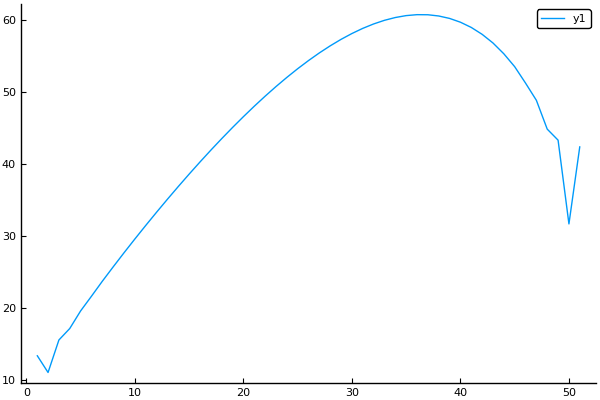

In [68]:
plot(fs[NS][:,2]*Δx^2)

## <span style="color:blue"> Plot </span>

#### Get body verts history

In [69]:
@get bd (bs, js, sys)

# get verts info based on this regular grid solution
vshist = []
for i = 1:length(solns)
    bs, js, sys = UpdatePosition!(bs, js, sys, solns[i].qJ)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

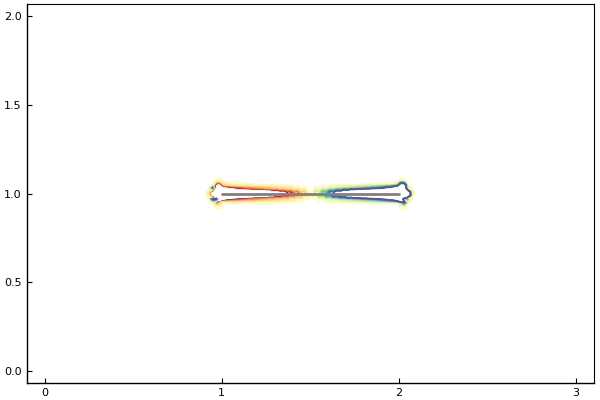

/home/julia/JuliaPro-0.6.2.2/JuliaPro/pkgs-0.6.2.2/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [70]:
p1 = plot(xg,yg,uhist[1],levels=linspace(-0.2,0.2,30))
for i = 1:sys.nbody
    plot!(p1,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey")
end
p1

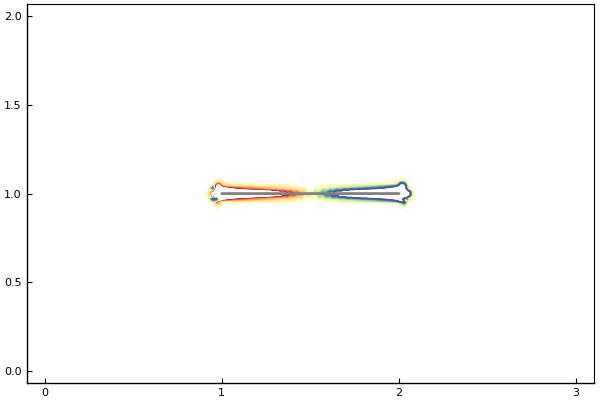

In [71]:
p2 = plot(xg,yg,uhist[end],levels=linspace(-0.2,0.2,30))
for i = 1:sys.nbody
    plot!(p2,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="grey")
end
p2

#### Body position begining and end

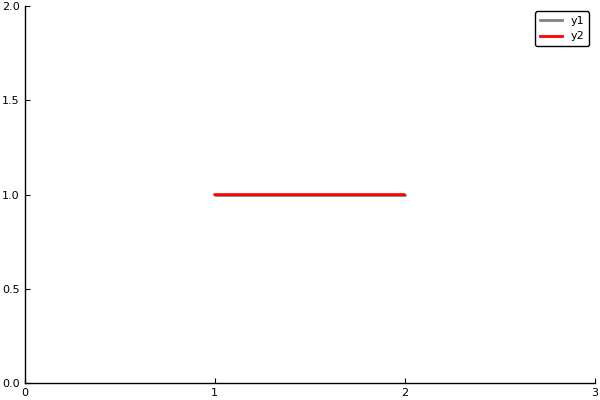

In [72]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red")
end
plot!(pb,xlims=(0,3), ylims=(0,2))
pb

#### Gif!

In [73]:
@gif for j = 1:length(uhist)
    plot(xg,yg,uhist[j],levels=linspace(-0.2,0.2,30))
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="grey")
    end
end

INFO: Saved animation to /media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/tmp.gif


Plots.AnimatedGif("/media/ruizhi/Seagate Expansion Drive/Research/Dyn3d.jl/notebook/tmp.gif")

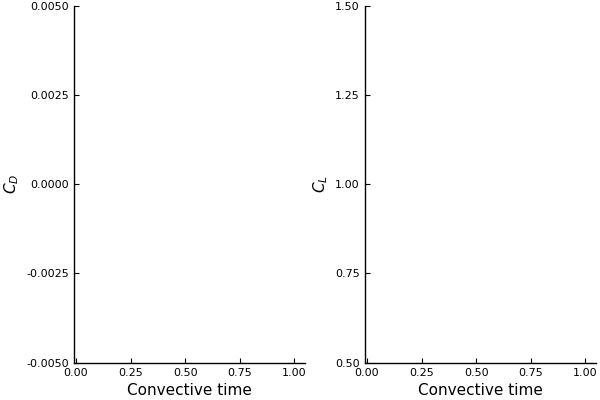

In [74]:
px = plot(thist,2*fx,ylim=(-0.005,0.005),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0.5,1.5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

In [75]:
fx

1-element Array{Float64,1}:
 14.5652

In [76]:
fy

1-element Array{Float64,1}:
 -2.16266e5